<a href="https://colab.research.google.com/github/elif-cetiin/personal-finance-dashboard/blob/main/notebooks/01-data-cleaning-and-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pandas matplotlib --quiet

import os
os.makedirs("data", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
print("Folders ready: data/ and outputs/")


Folders ready: data/ and outputs/


In [3]:
import os

file_path = "data/example_transactions.csv"

# create a minimal CSV if not exists
if not os.path.exists(file_path):
    csv_content = (
        "date,description,amount,currency,type\n"
        "2025-01-01,Starbucks,-5.25,USD,debit\n"
        "2025-01-01,Walmart,-42.70,USD,debit\n"
        "2025-01-02,Uber,-18.00,USD,debit\n"
        "2025-01-03,Amazon,-65.23,USD,debit\n"
        "2025-01-05,Salary,2500.00,USD,credit\n"
        "2025-01-06,Shell Gas,-32.90,USD,debit\n"
    )

    with open(file_path, "w", encoding="utf-8") as f:
        f.write(csv_content)

    print("example_transactions.csv created successfully")
else:
    print("example_transactions.csv already exists")



example_transactions.csv created successfully


In [4]:
import pandas as pd

df = pd.read_csv("data/example_transactions.csv")

print("Shape (rows, columns):", df.shape)
display(df.head())
print("\nData types:")
print(df.dtypes)


Shape (rows, columns): (6, 5)


,date,description,amount,currency,type
0,2025-01-01,Starbucks,-5.25,USD,debit
1,2025-01-01,Walmart,-42.70,USD,debit
2,2025-01-02,Uber,-18.00,USD,debit
3,2025-01-03,Amazon,-65.23,USD,debit
4,2025-01-05,Salary,2500.00,USD,credit



Data types:
date            object
description     object
amount         float64
currency        object
type            object
dtype: object


In [5]:
# parse dates, clean text, drop missing

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["description"] = df["description"].astype(str).str.strip()
df["type"] = df["type"].astype(str).str.lower().str.strip()

# drop rows with missing critical fields
before = len(df)
df = df.dropna(subset=["date", "amount", "description"])
after = len(df)

df = df.sort_values("date").reset_index(drop=True)

print(f"Rows dropped during cleaning: {before - after}")
display(df.head())


Rows dropped during cleaning: 0


,date,description,amount,currency,type
0,2025-01-01,Starbucks,-5.25,USD,debit
1,2025-01-01,Walmart,-42.70,USD,debit
2,2025-01-02,Uber,-18.00,USD,debit
3,2025-01-03,Amazon,-65.23,USD,debit
4,2025-01-05,Salary,2500.00,USD,credit


In [6]:
# derived columns and simple keyword-based categorizer
df["abs_amount"] = df["amount"].abs()
df["month"] = df["date"].dt.to_period("M").astype(str)
df["type"] = df["type"].fillna("").str.lower().str.strip()

# if type missing infer from amount sign
df.loc[df["type"] == "", "type"] = df.loc[df["type"] == "", "amount"].apply(lambda x: "credit" if x > 0 else "debit")

# editable keyword-to-category mapping
CATEGORY_KEYWORDS = {
    "Coffee": ["starbucks", "coffee", "espresso"],
    "Groceries": ["walmart", "grocery", "aldi", "kroger"],
    "Transport": ["uber", "lyft", "taxi", "bus", "metro", "shell gas", "gas"],
    "Shopping": ["amazon", "mall", "shop", "store"],
    "Salary": ["salary", "payroll", "paycheck"],
    "Fuel": ["shell", "exxon", "bp", "chevron"],
    "Other": []
}

def categorize_description(desc):
    desc_lower = str(desc).lower()
    for cat, keys in CATEGORY_KEYWORDS.items():
        for k in keys:
            if k in desc_lower:
                return cat
    return "Other"

df["category"] = df["description"].apply(categorize_description)

# show results
display(df[["date","description","amount","abs_amount","type","category","month"]])
print("\nCategory counts:")
print(df["category"].value_counts())


,date,description,amount,abs_amount,type,category,month
0,2025-01-01,Starbucks,-5.25,5.25,debit,Coffee,2025-01
1,2025-01-01,Walmart,-42.70,42.70,debit,Groceries,2025-01
2,2025-01-02,Uber,-18.00,18.00,debit,Transport,2025-01
3,2025-01-03,Amazon,-65.23,65.23,debit,Shopping,2025-01
4,2025-01-05,Salary,2500.00,2500.00,credit,Salary,2025-01
5,2025-01-06,Shell Gas,-32.90,32.90,debit,Transport,2025-01



Category counts:
category
Transport    2
Coffee       1
Groceries    1
Shopping     1
Salary       1
Name: count, dtype: int64


,category,net_amount,total_spent,transactions
0,Salary,2500.00,2500.00,1
1,Shopping,-65.23,65.23,1
2,Transport,-50.90,50.90,2
3,Groceries,-42.70,42.70,1
4,Coffee,-5.25,5.25,1


,month,net_amount,total_spent
0,2025-01,2335.92,2664.08


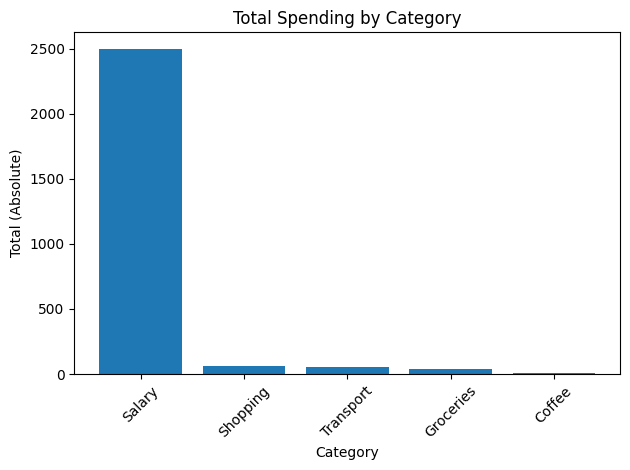

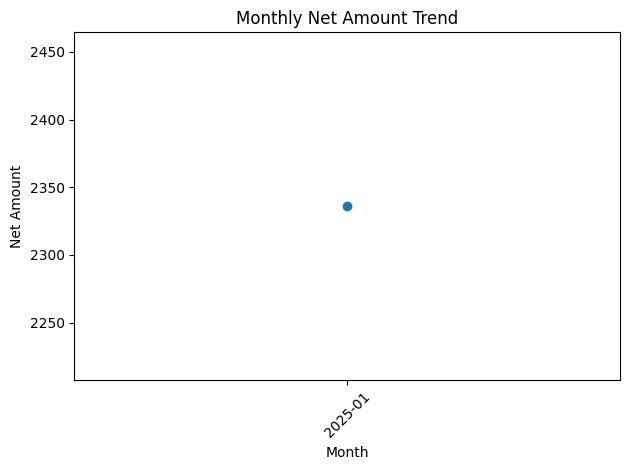

In [8]:
import matplotlib.pyplot as plt

# summary by category
cat_summary = df.groupby("category").agg(
    net_amount=("amount", "sum"),
    total_spent=("abs_amount", "sum"),
    transactions=("amount", "count")
).sort_values("total_spent", ascending=False).reset_index()

display(cat_summary)

# summary by month
monthly_summary = df.groupby("month").agg(
    net_amount=("amount", "sum"),
    total_spent=("abs_amount", "sum")
).reset_index()

display(monthly_summary)

# chart 1: spending by category
plt.figure()
plt.bar(cat_summary["category"], cat_summary["total_spent"])
plt.title("Total Spending by Category")
plt.xlabel("Category")
plt.ylabel("Total (Absolute)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/spending_by_category.png")
plt.show()

# chart 2: monthly net trend
plt.figure()
plt.plot(monthly_summary["month"], monthly_summary["net_amount"], marker="o")
plt.title("Monthly Net Amount Trend")
plt.xlabel("Month")
plt.ylabel("Net Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/monthly_net_trend.png")
plt.show()



In [9]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pandas as pd

# save cleaned CSV
cleaned_file = "outputs/cleaned_transactions.csv"
df.to_csv(cleaned_file, index=False)
print("Saved cleaned CSV to:", cleaned_file)

# generate PDF report
pdf_path = "outputs/report.pdf"

with PdfPages(pdf_path) as pdf:
    # Title Page
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis("off")
    ax.text(0.5, 0.6, "Personal Finance Dashboard Report", fontsize=20, ha="center")
    ax.text(0.5, 0.55, "Generated from example_transactions.csv", fontsize=12, ha="center")
    pdf.savefig(fig)
    plt.close(fig)

    # Summary Table: Category Analysis
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis("off")
    table = ax.table(cellText=cat_summary.round(2).values,
                     colLabels=cat_summary.columns,
                     loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    pdf.savefig(fig)
    plt.close(fig)

    # Add charts (if they exist)
    import os
    charts = ["outputs/spending_by_category.png", "outputs/monthly_net_trend.png"]
    for img in charts:
        if os.path.exists(img):
            fig = plt.figure(figsize=(8.5, 11))
            plt.imshow(plt.imread(img))
            plt.axis("off")
            pdf.savefig(fig)
            plt.close(fig)

print("PDF report created:", pdf_path)


Saved cleaned CSV to: outputs/cleaned_transactions.csv
PDF report created: outputs/report.pdf


In [10]:
from IPython.display import FileLink, display

display(FileLink("outputs/cleaned_transactions.csv"))
display(FileLink("outputs/report.pdf"))


/content/outputs/cleaned_transactions.csv

/content/outputs/report.pdf